# Offshore CIOPS Quantitative Runs
### what if using huyer 1998's divisions was a good idea...

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import datetime as dt
import math
import pandas as pd

In [2]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [3]:
meander = 0
init = 1
North = 2
Sshelf = 5
Sslope = 4
Offshore = 3
# sections = [North, Sshelf, Sslope, Offshore, meander]
# sec_name = ['north', 'south\nshelf', 'south\nslope', 'offshore', 'meander']

In [4]:
saltdiv = 32
tide = 24
sdep = -100 # change to 150 in the winter
offcut = 595 

#from huyer 1998, Masson 2006, and Sahu 2022
sdiv = 33.9
tdiv = 8.85

## summer 2017

In [5]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

In [6]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [7]:
mon_sum_ = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]

loop_ = [np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]
mon_sum = np.array(loop_)+np.array(mon_sum_)
loop = np.array(loop_)/np.array(mon_sum)

In [8]:
north = [np.sum(data.init_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) 
                                 & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

offshore = [np.sum(data.init_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) 
                                    & (data.final_x <= offcut) & (data.init_t >= sum_start[i]) 
                                    & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                    for i in range(len(sum_start))]

cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= sum_start[i])
                               & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                               for i in range(len(sum_start))]

south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= sum_start[i]) 
                                 & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.final_depth > sdep) & (data.init_t >= sum_start[i]) & 
                                 (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

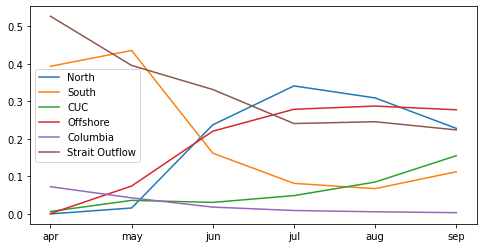

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(monS, north, label = "North")
ax.plot(monS, south, label = "South")
ax.plot(monS, cuc, label = "CUC")
ax.plot(monS, offshore, label='Offshore')
ax.plot(monS, fresh, label = "Columbia")
ax.plot(monS, loop, label = "Strait Outflow")

# ax.plot(monS, meander, label = "Strait Outflow")
ax.legend()

In [10]:
total = np.sum(mon_sum[2:])

north_bar = np.sum([north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
cuc_bar = np.sum([cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100])
south_bar = np.sum([south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) 
fresh_bar = np.sum([fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100]) 
loop_bar = np.sum([loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100]) 

Text(0, 0.5, 'Percentage of JdF Inflow')

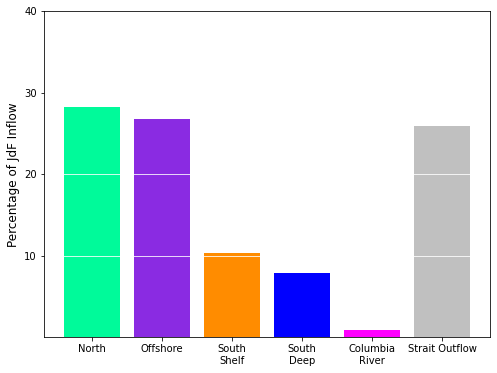

In [11]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'South\nDeep', 'Columbia\nRiver', 'Strait Outflow']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']
ax.bar(sec_name,[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar, loop_bar], color=colors)
ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [12]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([38.0713216 , 36.06403143, 13.98005734, 10.68170597,  1.20288366])

In [13]:
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar,loop_bar]

[28.217819997670276,
 26.730050451880974,
 10.36178217776439,
 7.917099897567929,
 0.8915570329697492,
 25.8816904421467]

In [14]:
np.sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar,loop_bar])

100.0

### Sv calcs

In [15]:
print('north = '+ str(np.mean(north[:2]*mon_sum[:2]/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore[:2]*mon_sum[:2]/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc[:2]*mon_sum[:2]/1000)) + ' mSv')
print('south = '+ str(np.mean(south[:2]*mon_sum[:2]/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh[:2]*mon_sum[:2]/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop[:2]*mon_sum[:2]/1000)) + ' mSv')

north = 0.7723858345148222 mSv
offshore = 3.6766899405317117 mSv
cuc = 2.059986282476729 mSv
south = 39.31208128763154 mSv
fresh = 5.414702272303941 mSv
loop = 43.477327445178446 mSv


In [ ]:
indep = -150

print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_depth <= sdep) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_depth <= sdep) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_depth > sdep) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_depth > sdep) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= sdep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')

cuc deep = 2.029060589790347 mSv
cuc shallow = 9.980581726613934 mSv
south deep = 1.821335157050796 mSv
south shallow = 5.7250253046582555 mSv
offshore deep = 5.523222024172333 mSv
offshore shallow = 21.744434076084442 mSv
offshore start deep = 16.750974967553454 mSv
north deep = 5.453324707426038 mSv
north shallow = 23.332023564944205 mSv
meander = 352.1065512482824 mSv


In [ ]:
2.029060589790347+ 1.821335157050796+ 5.523222024172333+ 5.453324707426038

14.826942478439515

In [ ]:

9.980581726613934+5.7250253046582555+21.744434076084442+23.332023564944205

60.782064672300834

## winter 2016/17

In [16]:
sdep = -150

In [17]:
dataS= xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [18]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [19]:
mons = np.append(mon16, ['apr17', 'may17'])

mon_sum_ = np.append([np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                    [np.sum(dataS.final_transp[(dataS.final_section!=0) & (np.isnan(dataS.final_section)==False) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])

loop_ = np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t > tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t-dataS.final_t > tide) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])
mon_sum = loop_+mon_sum_
loop = loop_/mon_sum

In [20]:
cuc = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.init_t >= win_start[i]) & (data.final_salt >= sdiv) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt >= sdiv) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

south = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_t >= win_start[i]) & (data.final_depth > sdep) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt >= saltdiv) & (dataS.final_salt < sdiv) & (dataS.init_t >= sum_start[i]) & (dataS.final_depth > sdep) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

fresh = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt < saltdiv) & (data.final_depth > sdep)& (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt < saltdiv)  & (dataS.final_depth > sdep) &(dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])


north = np.append([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==North) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

offshore = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Offshore),(dataS.final_section==Sslope)) & (dataS.final_x <= offcut) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

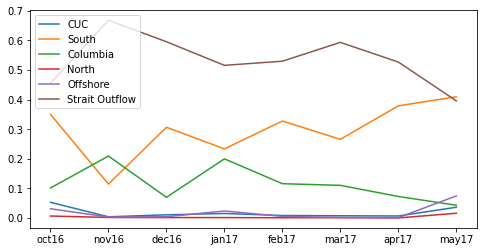

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mons, cuc, label = "CUC")
ax.plot(mons, south, label = "South")
ax.plot(mons, fresh, label = "Columbia")
ax.plot(mons, north, label = "North")
ax.plot(mons, offshore, label = "Offshore")
ax.plot(mons, loop, label = "Strait Outflow")

ax.legend()

In [22]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100,cuc[6]*mon_sum[6]/total*100,cuc[7]*mon_sum[7]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100,south[6]*mon_sum[6]/total*100,south[7]*mon_sum[7]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100,fresh[6]*mon_sum[6]/total*100,fresh[7]*mon_sum[7]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100,north[6]*mon_sum[6]/total*100,north[7]*mon_sum[7]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100,offshore[6]*mon_sum[6]/total*100,offshore[7]*mon_sum[7]/total*100])
loop_bar = np.sum([loop[0]*mon_sum[0]/total*100, loop[1]*mon_sum[1]/total*100, loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100,loop[6]*mon_sum[6]/total*100,loop[7]*mon_sum[7]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

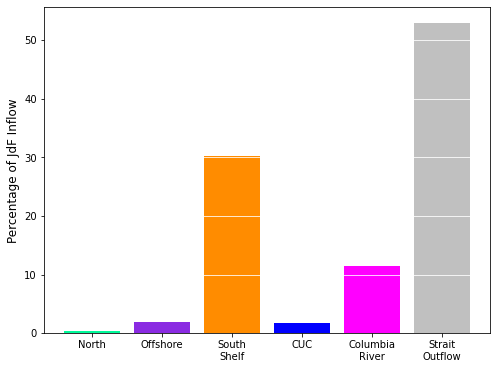

In [23]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = [ 'North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver', 'Strait\nOutflow']
# colors = ['teal',  'teal',  'teal', 'teal', 'teal']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar, loop_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [24]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar]

[0.35647108989160503,
 1.8987511261148766,
 30.178480932801122,
 1.7652756044378521,
 11.449376829737226,
 53.02597200078504]

In [25]:
# percentage south and fresh at 31.5
[south_bar,fresh_bar]

[30.178480932801122, 11.449376829737226]

In [26]:
# percentage south and fresh at 32.5
[south_bar,fresh_bar]

[30.178480932801122, 11.449376829737226]

In [27]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([ 0.78090675,  4.15951703, 66.11077343,  3.86711763, 25.08168516])

### how much is meandered?

In [28]:
# lets see how much is meandered from the different groups
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]  

In [29]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

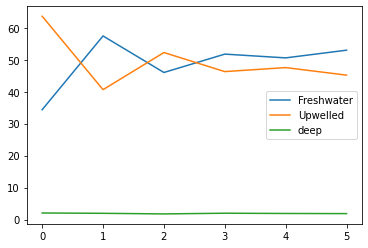

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

In [ ]:
# percentage meander
mean = np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])
# np.mean(np.array(mean)/(np.array(mean)+np.array(mon_sum)))

In [ ]:
tide=24

short = np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t < tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t-dataS.final_t < tide) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])


In [ ]:
mean

array([371300.5277822 , 408882.43037637, 418377.33661322, 404841.66742998,
       389407.17079521, 396305.64184844, 386981.52560798, 373312.09479314])

In [ ]:
short

array([333574.36457041, 352926.29042459, 366401.04556279, 355606.70267596,
       335138.0826477 , 358619.21680341, 338673.99043887, 334664.9750719 ])

In [ ]:
np.mean((np.array(short)/np.array(mean)*100))

88.16100531426548

### Sv

In [28]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop*mon_sum/1000)) + ' mSv')

north = 0.3141154630447319 mSv
offshore = 1.6731429451057054 mSv
cuc = 1.5555268845453254 mSv
south = 26.592696521549488 mSv
fresh = 10.088970484366984 mSv
loop = 46.72546588136611 mSv


## winter 2017/18

In [29]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [30]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [31]:
mon_sum_ = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]

loop_ = [np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]
mon_sum = np.array(loop_)+np.array(mon_sum_)
loop = np.array(loop_)/np.array(mon_sum)

In [32]:
cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= win_start[i])
                               & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                               for i in range(len(win_start))]

south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= win_start[i]) 
                                 & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                                 for i in range(len(win_start))]

fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.final_depth > sdep) & (data.init_t >= win_start[i]) & 
                                 (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                                 for i in range(len(win_start))]

north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
offshore = [np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]

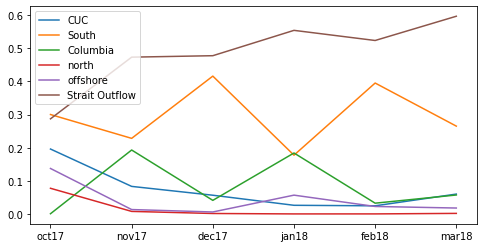

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mon17, cuc, label = "CUC")
ax.plot(mon17, south, label = "South")
ax.plot(mon17, fresh, label = "Columbia")
ax.plot(mon17, north, label = "north")
ax.plot(mon17, offshore, label = "offshore")
ax.plot(mon17, loop, label = "Strait Outflow")


ax.legend()

In [34]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
loop_bar = np.sum([loop[0]*mon_sum[0]/total*100, loop[1]*mon_sum[1]/total*100, loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

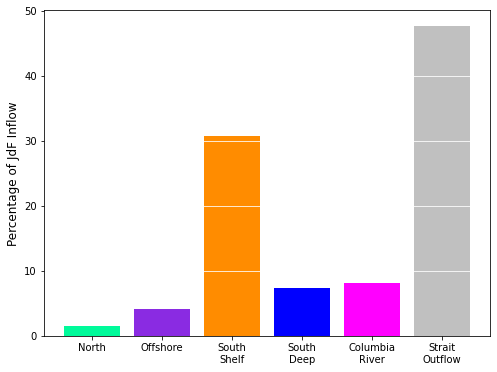

In [35]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'South\nDeep', 'Columbia\nRiver', 'Strait\nOutflow']
# colors = ['teal',  'teal',  'teal', 'teal', 'teal']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']

ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar, loop_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [36]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar]

[1.558714647968228,
 4.226084122159593,
 30.763756608473315,
 7.489403945263629,
 8.186109447077055,
 47.77574053995079]

In [37]:
# percentage south and fresh at 31.5
[south_bar,fresh_bar]

[30.763756608473315, 8.186109447077055]

In [38]:
# percentage south and fresh at 32.5
[south_bar,fresh_bar]

[30.763756608473315, 8.186109447077055]

In [39]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([ 2.98466719,  8.09221537, 58.90723824, 14.34090472, 15.67497447])

### how much is meandered?

In [ ]:
# lets see how much is meandered from the different groups
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]  

In [ ]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

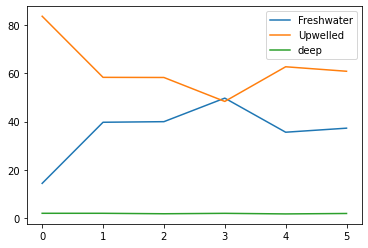

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

In [ ]:
# percentage meander
mean = [np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-sum_start[i]+1) for i in range(len(win_start))]
# np.mean(np.array(mean)/(np.array(mean)+np.array(mon_sum)))
mean

[<xarray.DataArray 'final_transp' ()>
 array(345248.37849797),
 <xarray.DataArray 'final_transp' ()>
 array(380403.71504668),
 <xarray.DataArray 'final_transp' ()>
 array(404667.43121579),
 <xarray.DataArray 'final_transp' ()>
 array(418391.12131285),
 <xarray.DataArray 'final_transp' ()>
 array(368827.25012917),
 <xarray.DataArray 'final_transp' ()>
 array(428717.19758371)]

In [ ]:
short = [np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t < tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-sum_start[i]+1) for i in range(len(win_start))]
short

[<xarray.DataArray 'final_transp' ()>
 array(318941.66193434),
 <xarray.DataArray 'final_transp' ()>
 array(335943.61485268),
 <xarray.DataArray 'final_transp' ()>
 array(359728.67513032),
 <xarray.DataArray 'final_transp' ()>
 array(378861.9406988),
 <xarray.DataArray 'final_transp' ()>
 array(309870.48664844),
 <xarray.DataArray 'final_transp' ()>
 array(391529.78099539)]

In [ ]:
np.mean((np.array(short)/np.array(mean)*100))

89.24678196407122

### Sv

In [40]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop*mon_sum/1000)) + ' mSv')

north = 1.3802585523807227 mSv
offshore = 3.742242853940292 mSv
cuc = 6.631947586531417 mSv
south = 27.241636702107773 mSv
fresh = 7.248887786985787 mSv
loop = 42.30593108401561 mSv


In [41]:
indep = -150

print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)& (data.final_depth <= sdep) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_depth <= sdep) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)& (data.init_salt >= saltdiv) & (data.final_depth > sdep) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)& (data.init_salt >= saltdiv) & (data.final_depth > sdep) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= sdep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(6)])/1000) + ' mSv')

cuc deep = 1.1536811927018276 mSv
cuc shallow = 3.619831089122276 mSv


south deep = 7.865627183738132 mSv
south shallow = 19.39237080629309 mSv
offshore deep = 0.7326276703961571 mSv
offshore shallow = 3.0400895620142148 mSv
offshore start deep = 0.2111542358177412 mSv
north deep = 0.23775031836173105 mSv
north shallow = 1.178280978644909 mSv


# bring it all together

In [42]:
Ssdep = -100
Wsdep = -150

In [43]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope) & (mydata.final_x > offcut)) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north16 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loop16 = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]

freshS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cucS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
southS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
northS = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoreS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loopS = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv)& (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north17 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loop17 = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


fresh = np.append(np.append(fresh16, freshS), fresh17)
south = np.append(np.append(south16, southS), south17)
north = np.append(np.append(north16, northS), north17)
cuc = np.append(np.append(cuc16, cucS), cuc17)
offshore = np.append(np.append(offshore16, offshoreS), offshore17)
loop = np.append(np.append(loop16, loopS), loop17)

In [44]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [45]:
N = 4
loop_avg = running_mean(loop, N)

In [46]:
dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(cuc))]

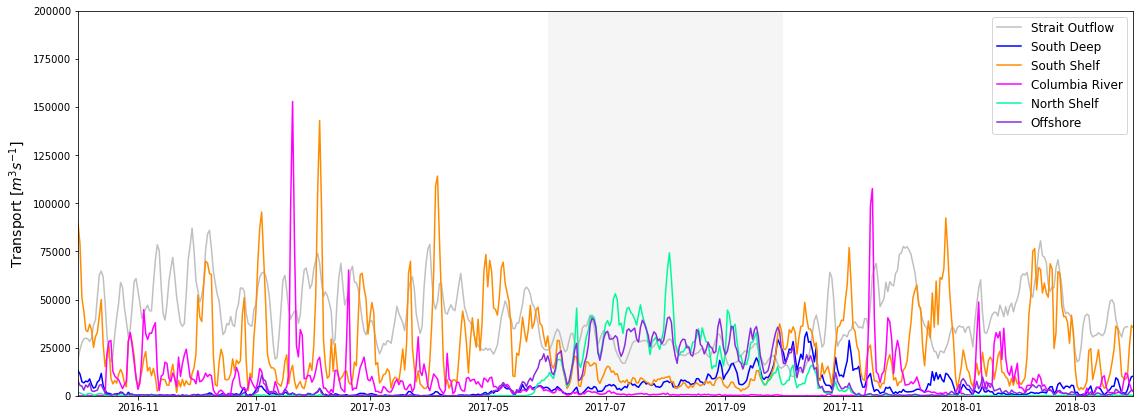

In [47]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates[:-(N-1)], loop_avg, label = "Strait Outflow", c='silver')
# ax.plot(dates, loop, label = "Strait Outflow", c='silver')
ax.plot(dates, cuc, label = "South Deep", c='b')
ax.plot(dates, south, label = "South Shelf", c='darkorange')
ax.plot(dates, fresh, label = "Columbia River", c='magenta')
ax.plot(dates, north, label = "North Shelf", c='mediumspringgreen')
ax.plot(dates, offshore, label = "Offshore", c='blueviolet')
ax.legend(loc='upper right')
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
# ax.set_ylim([0,55000]);
ax.set_ylim([0,200000])
ax.set_xlim([dates[0],dates[-1]])

ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke')

plt.tight_layout()
plt.savefig("./figures/dailyWMtoJRT.pdf")



In [48]:
# lets have a subplot with wind speed and direction at destruction island
wind = pd.read_csv('desw.csv', usecols=['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD'], header=0).drop(0)
d = {'year':wind['#YY'],'month':wind['MM'],'day':wind['DD'],'hour':wind['hh'],'minute':wind['mm']}
w_date = pd.DataFrame(d)
wind['datetime'] = pd.to_datetime(w_date)
wind = wind.set_index('datetime')

wind['WDIR'] = pd.to_numeric(wind['WDIR'])
wind['WSPD'] = pd.to_numeric(wind['WSPD'])
wind['Wrad'] = np.deg2rad(wind['WDIR'])
wind['northward'] = wind['WSPD']*np.cos(wind['WDIR'])
wind = wind.resample('D').mean()

<ipython-input-48-6a7ec972fdf1>:2: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv('desw.csv', usecols=['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD'], header=0).drop(0)


(17075.0, 17621.0)

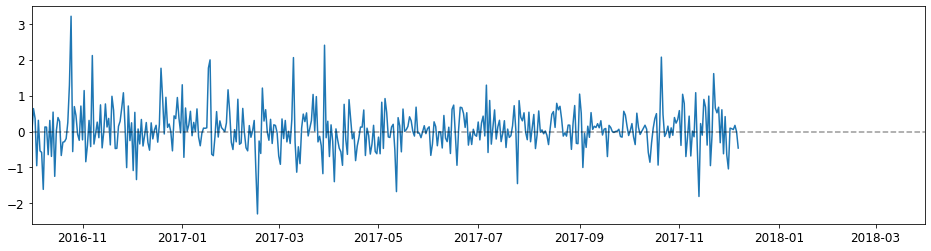

In [49]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(wind.northward)
ax.plot([dates[0],dates[-1]],[0,0],'k--',alpha=0.4)
ax.set_xlim([dates[0],dates[-1]])

(17075.0, 17621.0)

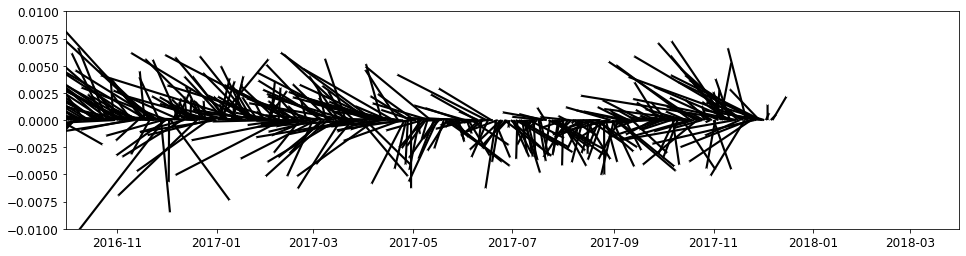

In [50]:
U = np.cos(wind.Wrad) * wind.WSPD
V = np.sin(wind.Wrad) * wind.WSPD

fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.quiver(wind.index,np.zeros(len(wind.index)),U,V, headwidth=0,scale=100)
ax.set_ylim([-0.01,0.01])
ax.set_xlim([dates[0],dates[-1]])

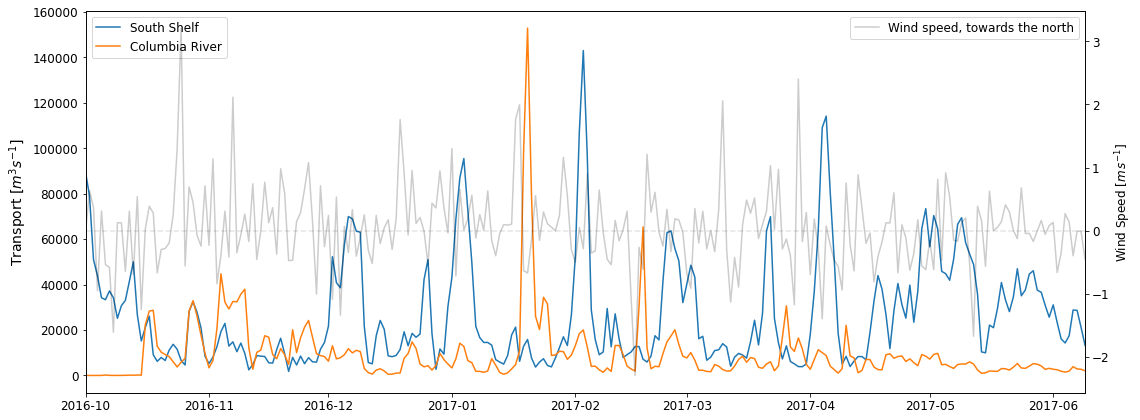

In [51]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates, south, label = "South Shelf")
ax.plot(dates, fresh, label = "Columbia River")

ax2 = ax2=ax.twinx()
ax2.plot(wind.index,wind.northward,c='k', label='Wind speed, towards the north', alpha = 0.2)
ax2.plot([dates[0],dates[-1]],[0,0],'k--',alpha=0.1)
ax2.set_ylabel('Wind Speed [$m\,s^{-1}$]')
ax2.plot()
# ax2.quiver(wind.index,np.zeros(len(wind.index)),U,V, headwidth=0,scale=100)
# ax2.plot(wind.index,wind.WDIR,'k--',label='wind direction', alpha = 0.3)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
# ax.set_ylim([0,55000]);
# ax.set_ylim([0,200000])
ax.set_xlim([dates[0],dates[251]])

# ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke', alpha=0.4)

plt.tight_layout()
plt.savefig("./figures/columbiawind.pdf")

Text(0, 0.5, 'Cumulative Transport [$m^{3}s^{-1}$]')

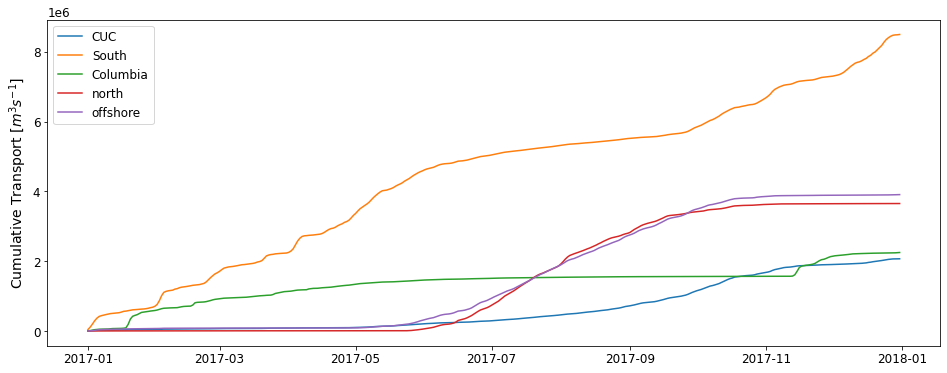

In [52]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates[92:457], np.cumsum(cuc[92:457]), label = "CUC")
ax.plot(dates[92:457], np.cumsum(south[92:457]), label = "South")
ax.plot(dates[92:457], np.cumsum(fresh[92:457]), label = "Columbia")
ax.plot(dates[92:457], np.cumsum(north[92:457]), label = "north")
ax.plot(dates[92:457], np.cumsum(offshore[92:457]), label = "offshore")
ax.legend(loc='upper left')
ax.set_ylabel('Cumulative Transport [$m^{3}s^{-1}$]',fontsize=14)

In [53]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(north[243:364], offshore[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], cuc[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
corr, _ = pearsonr(north[243:364], south[243:364])
print('Pearsons correlation with south: %.3f' % corr)
corr, _ = pearsonr(cuc[243:364], south[243:364])
print('Pearsons correlation cuc and south summer: %.3f' % corr)

Pearsons correlation with offshore: 0.684
Pearsons correlation with cuc: -0.092
Pearsons correlation with south: -0.105
Pearsons correlation cuc and south summer: 0.169


In [54]:
corr, _ = pearsonr(np.append(fresh[:215],fresh[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation fresh and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation cuc and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(fresh[:215],fresh[364:]))
print('Pearsons correlation cuc and fresh winter: %.3f' % corr)

Pearsons correlation fresh and south winter: -0.118
Pearsons correlation cuc and south winter: 0.292
Pearsons correlation cuc and fresh winter: -0.204


In [ ]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(offshoredeep[243:364], cuc[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], offshoredeep[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
# corr, _ = pearsonr(north[243:364], [243:364])
# print('Pearsons correlation with south: %.3f' % corr)

NameError: name 'offshoredeep' is not defined

(0.0, 150000.0)

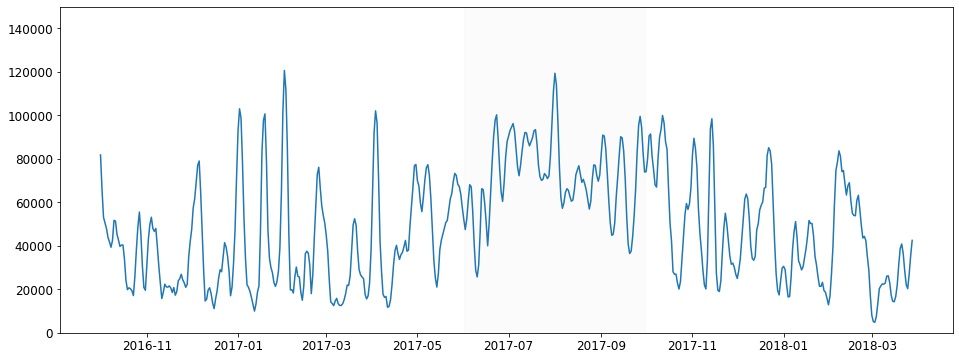

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
N=4
ax.plot(dates[:-(N-1)], np.sum([running_mean(cuc, N),running_mean(fresh, N),running_mean(north, N),running_mean(south, N),running_mean(offshore, N)],axis=0))
# ax.set_ylim([0,90000]);
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke', alpha=0.4)
ax.set_ylim([ 0,150000])